### Redes Neurais e Aprendizado Profundo
#### **MBA em Ciências de Dados**

### *Módulo 4 - Treinamento de Redes Profundas*

**Aumentação de Dados e Transferência de Aprendizado**</span>

Moacir Antonelli Ponti

---

In [30]:
%%capture
!pip install tensorflow_datasets tfds-nightly datasets

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy.random import seed
from tensorflow.random import set_seed

import tensorflow_datasets as tfds

# selecionamos 50% do treinamento
(train_ds, validation_ds, test_ds), info = tfds.load(
    "huggingface:beans",
    split=["train[0%:50%]", "validation[0%:100%]", "test[0%:100%]"],
    as_supervised=True,
    with_info=True
)

/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/core/dataset_builders/huggingface_dataset_builder.py:159: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  hf_names = hf_datasets.list_datasets()


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.0.0.incomplete6TS829/beans-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.0.0.incomplete6TS829/beans-validation.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.0.0.incomplete6TS829/beans-test.tfrecord*...:   0%|          | 0/1…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.0.0. Subsequent calls will reuse this data.


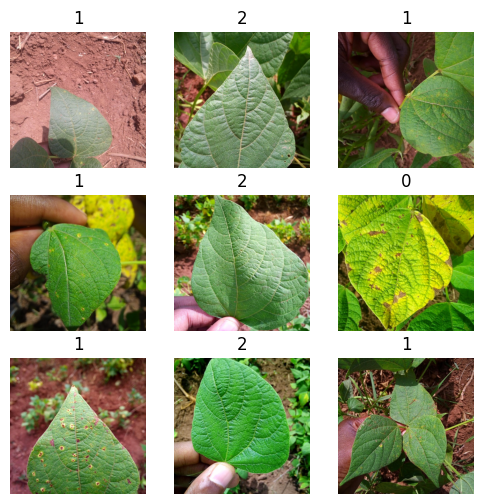

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")


In [7]:
print(info)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# redimensionando exemplos e normalizando entre 0-1 tipo float32
img_size = (128, 128)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), tf.one_hot(y,3)))
train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, img_size), tf.one_hot(y,3)))
validation_ds = validation_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), tf.one_hot(y,3)))
test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

input_shape = img_size+(3,)

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.0.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
    by experts from the National Crops Resources Research Institute (NaCRRI) in
    Uganda and collected by the Makerere AI research lab.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/beans',
    data_dir='/root/tensorflow_datasets/beans/0.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=637.84 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image_file_path': Scalar(shape=(), dtype=string),
        'labels': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'labels'),
    disable_shuffling=False,
    splits={
        't

In [8]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

---

### Data Augmentation:
#### funciona como uma camada de pré-processamento, gerando transformações aleatórias na imagem de entrada.

Ao longo das épocas é responsável pela perturbação da entrada.

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomFlip("vertical"),
        layers.experimental.preprocessing.RandomRotation(0.25),
        layers.experimental.preprocessing.RandomContrast(0.3),
    ]
)

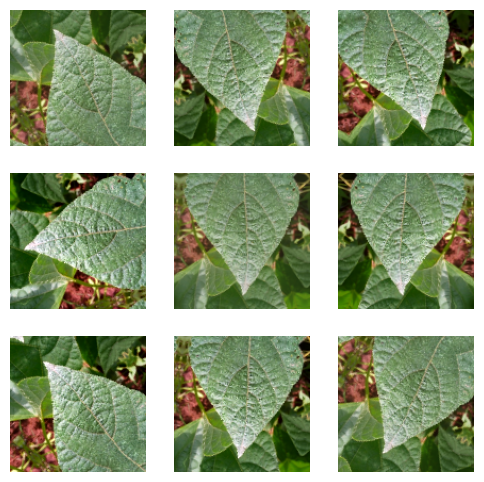

In [10]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(6, 6))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(images[1], 0), training=True
        )
        #plt.title(str(labels[i].numpy()))
        plt.imshow(augmented_image[0].numpy())
        plt.axis("off")


---
### Carregando a CNN "MobileNet V2" para ser usada como "backbone" da solução

**Abordagem 1**: pesos inicializados aleatoriamente

carregamos `include_top=False` pois não queremos a última camada (top), especifica da ImageNet


In [11]:
base_model_random = tf.keras.applications.MobileNetV2(
    weights=None,
    input_shape=(128, 128, 3),
    include_top=False
)

# Permitir treinamento do modelo carregado
base_model_random.trainable = True

# Com base na MobileNetV2 vamos criar nosso modelo
# definimos o tamanho da entrada
inputs = keras.Input(shape=(128, 128, 3))
# aplicamos a transformacao da imagem de entrada
x = data_augmentation(inputs)

# Depois da "aumentacao de dados", temos o modelo base
x = base_model_random(x, training=True)
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(3,activation="softmax")(x)

model_random = keras.Model(inputs, outputs)

model_random.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843  

#### Compilando e treinando o modelo a partir de pessos aleatórios

In [12]:
seed(1)
set_seed(2)

model_random.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss="categorical_crossentropy",
    metrics=["acc"],
)

epochs = 20
rand_hist = model_random.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
17/17 [==============================] - 41s 413ms/step - loss: 1.2669 - acc: 0.3288 - val_loss: 1.0759 - val_acc: 0.3985
Epoch 2/20
17/17 [==============================] - 2s 94ms/step - loss: 1.1455 - acc: 0.3675 - val_loss: 1.0516 - val_acc: 0.4662
Epoch 3/20
17/17 [==============================] - 2s 98ms/step - loss: 1.0815 - acc: 0.4507 - val_loss: 1.0359 - val_acc: 0.4962
Epoch 4/20
17/17 [==============================] - 1s 86ms/step - loss: 1.0714 - acc: 0.4584 - val_loss: 1.0049 - val_acc: 0.4962
Epoch 5/20
17/17 [==============================] - 2s 114ms/step - loss: 1.0419 - acc: 0.4681 - val_loss: 0.9470 - val_acc: 0.5714
Epoch 6/20
17/17 [==============================] - 2s 130ms/step - loss: 0.9997 - acc: 0.4952 - val_loss: 0.9284 - val_acc: 0.5338
Epoch 7/20
17/17 [==============================] - 2s 90ms/step - loss: 0.9758 - acc: 0.5300 - val_loss: 0.9358 - val_acc: 0.5338
Epoch 8/20
17/17 [==============================] - 1s 80ms/step - loss: 0.9208

In [13]:
scores = model_random.evaluate(validation_ds)
print('Inicializacao Aleatoria. Scores: ', scores)

5/5 [==============================] - 0s 17ms/step - loss: 0.8032 - acc: 0.6241
Inicializacao Aleatoria. Scores:  [0.803225040435791, 0.6240601539611816]


---
### Carregando a CNN "MobileNet V2" com pesos pré-treinados

**Abordagem 2**: uso de pesos pré-treinados na imagenet para Transferência de Aprendizado


In [14]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128, 128, 3),
    include_top=False
)

# Tornamos o modelo base não treinável, "congelando" os parâmetros
base_model.trainable = False

# Nosso modelo como anteriormente
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)

# Incluindo a MobileNetV2 com parametros pré-treinados, mas ainda não treinável
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = keras.layers.Dense(160,activation="relu", name="projection")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(3,activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 projection (Dense)          (None, 160)               204960    
                                                              

#### Passo 1: treinar apenas a camada de saída (softmax)


In [15]:
seed(1)
set_seed(2)

model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss="categorical_crossentropy",
    metrics=["acc"],
)

epochs = 16
pt_hist1 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/16
17/17 [==============================] - 6s 83ms/step - loss: 1.3638 - acc: 0.3617 - val_loss: 1.0032 - val_acc: 0.4737
Epoch 2/16
17/17 [==============================] - 0s 26ms/step - loss: 0.9193 - acc: 0.5977 - val_loss: 0.8219 - val_acc: 0.6767
Epoch 3/16
17/17 [==============================] - 0s 25ms/step - loss: 0.7436 - acc: 0.6712 - val_loss: 0.7114 - val_acc: 0.7218
Epoch 4/16
17/17 [==============================] - 0s 27ms/step - loss: 0.7014 - acc: 0.6847 - val_loss: 0.6978 - val_acc: 0.7368
Epoch 5/16
17/17 [==============================] - 0s 26ms/step - loss: 0.6439 - acc: 0.7311 - val_loss: 0.6314 - val_acc: 0.7594
Epoch 6/16
17/17 [==============================] - 0s 27ms/step - loss: 0.5690 - acc: 0.7679 - val_loss: 0.6176 - val_acc: 0.7744
Epoch 7/16
17/17 [==============================] - 0s 26ms/step - loss: 0.5485 - acc: 0.7640 - val_loss: 0.5823 - val_acc: 0.7744
Epoch 8/16
17/17 [==============================] - 0s 25ms/step - loss: 0.5644 - a

In [16]:
scores = model.evaluate(validation_ds)
print('Transferencia do Aprendizado de Representacaoes. Scores: ', scores)

5/5 [==============================] - 0s 18ms/step - loss: 0.4868 - acc: 0.8346
Transferencia do Aprendizado de Representacaoes. Scores:  [0.4867912232875824, 0.8345864415168762]


#### Passo 2: ajuste fino do restante dos parâmetros

Executamos mais algumas épocas para tentar melhorar as outras camadas

In [17]:
# des-congelando o modelo base, permitindo ser treinável

# modelo completo
base_model.trainable = True

# congelando as primeiras camadas, deixando apenas as ultimas treinaveis
for layer in base_model.layers[:-4]:
    layer.trainable = False
    # congela tambem camadas de BN
    if isinstance(layer, keras.layers.BatchNormalization):
        layer._per_input_updates = {}

# verificando
for layer in base_model.layers[-8:]: print(layer, layer.trainable)
# note a diferença no summary
model.summary()

<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x790986a2d000> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x790986a2f610> False
<keras.src.layers.activation.relu.ReLU object at 0x790986a2ef50> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x790986a2de40> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x790986a4d2d0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x790986a4e500> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x790986a4ec20> True
<keras.src.layers.activation.relu.ReLU object at 0x790986a4f730> True
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequen

In [18]:
# aqui definimos um passo/learning rate bem pequeno para o ajuste-fino
model.compile(
    optimizer=keras.optimizers.Adam(10e-7),
    loss="categorical_crossentropy",
    metrics=["acc"],
)

epochs = 5
pt_hist2 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/5
17/17 [==============================] - 7s 81ms/step - loss: 0.4464 - acc: 0.8279 - val_loss: 0.4884 - val_acc: 0.8346
Epoch 2/5
17/17 [==============================] - 0s 27ms/step - loss: 0.4152 - acc: 0.8317 - val_loss: 0.4900 - val_acc: 0.8271
Epoch 3/5
17/17 [==============================] - 0s 27ms/step - loss: 0.3764 - acc: 0.8569 - val_loss: 0.4910 - val_acc: 0.8271
Epoch 4/5
17/17 [==============================] - 0s 26ms/step - loss: 0.4125 - acc: 0.8472 - val_loss: 0.4919 - val_acc: 0.8271
Epoch 5/5
17/17 [==============================] - 0s 27ms/step - loss: 0.3874 - acc: 0.8395 - val_loss: 0.4918 - val_acc: 0.8195


In [19]:
scores = model.evaluate(validation_ds)
print('Ajuste Fino. Scores validacao: ', scores)

5/5 [==============================] - 0s 16ms/step - loss: 0.4918 - acc: 0.8195
Ajuste Fino. Scores validacao:  [0.4917595684528351, 0.8195488452911377]


Comparando o histórico das duas abordagens

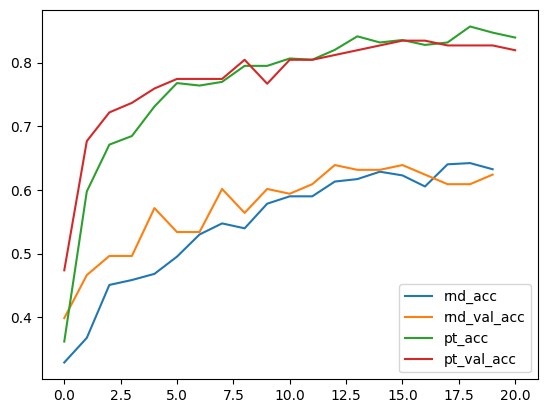

In [20]:
pt_tra_hist = np.concatenate((pt_hist1.history['acc'], pt_hist2.history['acc']), axis=None)
pt_val_hist = np.concatenate((pt_hist1.history['val_acc'], pt_hist2.history['val_acc']), axis=None)

plt.plot(rand_hist.history['acc'])
plt.plot(rand_hist.history['val_acc'])
plt.plot(pt_tra_hist)
plt.plot(pt_val_hist)
plt.legend(['rnd_acc','rnd_val_acc','pt_acc','pt_val_acc'])

---
### Obtendo features a partir da CNN "MobileNet V2" com pesos pré-treinados

**Abordagem 3**: obter a saída dessa rede, sem incluir a camada de predição (softmax).

Esse processo *não necessita de treinamento* da rede. Para obter features, incluímos uma nova camada, de Global Pooling e definimos essa camada como sendo a de saída do modelo.

Aqui também não incluimos o "topo" da rede, cujas camadas dependem de uma entrada de tamanho igual a da ImageNet (224x224) e saída com 1000 classes.

In [21]:
# carregando pessos pré-treinados
base_model_extraction = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128, 128, 3),
    include_top=False
)

# obtemos a camada de saída do modelo carregado (última camada pois não incluímos o topo da rede)
base_output = base_model_extraction.layers[-1].output

# para evitar uma dimensionalidade alta, definimos uma nova camada de saída
feat_layer = keras.layers.GlobalAveragePooling2D()(base_output)

# montamos um novo modelo com a entrada do pré-treinado, e saída criada acima
model_imagenet = keras.models.Model(base_model_extraction.inputs, feat_layer)

# passando os exemplos de treinamento pela rede sem treinamento
# o "predict" vai nos dar a saída programada, obtida da GlobalAveragePooling2D
features_train_mobilenet = np.array(model_imagenet.predict(train_ds))
features_val_mobilenet = np.array(model_imagenet.predict(validation_ds))
features_test_mobilenet = np.array(model_imagenet.predict(test_ds))

print('\tDados x features obtidas treinamento: ', features_train_mobilenet.shape)
print('\tDados x features obtidas test: ', features_test_mobilenet.shape)

4/4 [==============================] - 1s 224ms/step
	Dados x features obtidas treinamento:  (517, 1280)
	Dados x features obtidas test:  (128, 1280)


As features obtidas podem ser utilizadas para treinar classificadores não profundos ou como índices de sistemas de recuperação baseada em conteúdo.

Vamos visualizá-las utilizando uma projeção PCA em duas dimensões

In [22]:
from sklearn.decomposition import PCA

# pca com dados da ImageNet
pca = PCA(n_components=2)
pca.fit(features_train_mobilenet)
pca_train_imagenet = pca.transform(features_train_mobilenet)

In [23]:
print(pca.explained_variance_)

[48.091118 35.0982  ]


In [24]:
# obtem labels treinamento
train_ds2 = train_ds.map(lambda x, y: (x, tf.math.argmax(y,axis=1)))
train_labels = list(np.concatenate([y for x, y in train_ds2], axis=0))

# obtem labels da validacao
validation_ds2 = validation_ds.map(lambda x, y: (x, tf.math.argmax(y,axis=1)))
val_labels = list(np.concatenate([y for x, y in validation_ds2], axis=0))

# obtem labels do teste
test_ds2 = test_ds.map(lambda x, y: (x, tf.math.argmax(y,axis=1)))
test_labels = list(np.concatenate([y for x, y in test_ds2], axis=0))

In [25]:
pca_train_imagenet.shape

(517, 2)

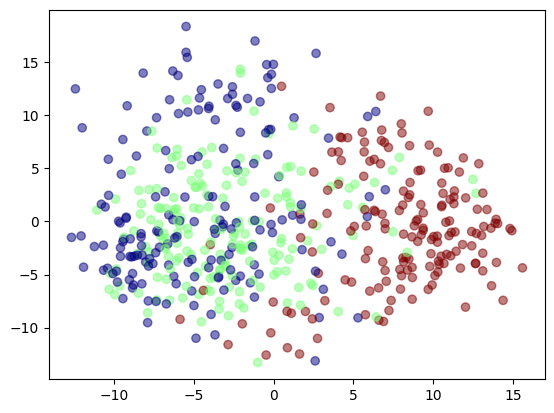

In [26]:
colors = ((np.array(train_labels)/2)*100).astype(int)
plt.scatter(pca_train_imagenet[:,0], pca_train_imagenet[:,1], c=colors, alpha=0.5, cmap='jet')

Usando em um classificador externo

In [27]:
from sklearn.svm import SVC

svm_feat1 = SVC(C=10, probability=True)
svm_feat1.fit(features_train_mobilenet, train_labels)

SVC(C=10, probability=True)

In [28]:
print('Acurácia Treinamento:')
print(svm_feat1.score(features_train_mobilenet, train_labels))
print('Acurácia Validacao:')
print(svm_feat1.score(features_val_mobilenet, val_labels))

Acurácia Treinamento:
1.0
Acurácia Validacao:
0.9097744360902256


---
Resumo comparativo das abordagens:

1. Treinamento a partir de pesos aleatórios
2. Pré-treinamento + Transferência de Aprendizado e Ajuste Fino
3. Extração de Características + Classificador Externo

In [29]:
scoresR = model_random.evaluate(test_ds, verbose=0)
scoresTL = model.evaluate(test_ds, verbose=0)
scoresF = svm_feat1.score(features_test_mobilenet, test_labels)

print('MobileNet treinada de pesos aleatorios: ', scoresR[1]*100)
print('MobileNet pré-treinada + ajuste fino: ', scoresTL[1]*100)
print('Features MobileNet + SVM: ', scoresF*100)

MobileNet treinada de pesos aleatorios:  59.375
MobileNet pré-treinada + ajuste fino:  78.125
Features MobileNet + SVM:  86.71875
